In [1]:
import pandas as pd
import numpy as np
import json
import os
import collections
import ast
from tqdm import tqdm
import matplotlib.pyplot as plt
import powerlaw
from scipy.stats import ks_2samp

# Ustawienia dla czytelności wykresów
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Analiza danych empirycznych (DBLP) 

Wczytujemy dane publikacji ze zbioru DBLP. Celem jest zliczenie referencji dla każdego artykułu, aby stworzyć empiryczny rozkład cytowań.

In [3]:
# Lokalizacja danych (dostosuj ścieżkę do swojego środowiska)
directory_path = "../../data/external/dblp-ref-10"
publications = []

# Wczytywanie plików JSON i zbieranie informacji o cytowaniach
file_names = [f for f in os.listdir(directory_path) if f.endswith('.json')]
for file_name in file_names:
    print(f"Przetwarzanie: {file_name}")
    with open(os.path.join(directory_path, file_name)) as input_file:
        for line in tqdm(input_file):
            publication = json.loads(line)
            # Wyciągamy tylko n_citation lub zliczamy z listy references
            publications.append(publication.get('n_citation', 0))

# Tworzenie rozkładu: ile jest prac z daną liczbą cytowań
dblp_distribution = collections.Counter(publications)

# Konwersja na format do analizy statystycznej
sorted_keys = sorted(dblp_distribution.keys())
sorted_values = [dblp_distribution[key] for key in sorted_keys]

print(f"Przetworzono {len(publications)} publikacji.")

Przetwarzanie: dblp-ref-0.json


1000000it [00:05, 174393.50it/s]


Przetwarzanie: dblp-ref-1.json


1000000it [00:06, 163400.36it/s]


Przetwarzanie: dblp-ref-2.json


1000000it [00:06, 161732.10it/s]


Przetwarzanie: dblp-ref-3.json


79007it [00:00, 184583.36it/s]

Przetworzono 3079007 publikacji.


### 1.1 Dopasowanie rozkładu potęgowego (Power Law) 

Sprawdzamy, czy dane empiryczne podlegają prawu potęgowemu i wizualizujemy wyniki na wykresie log-log.

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


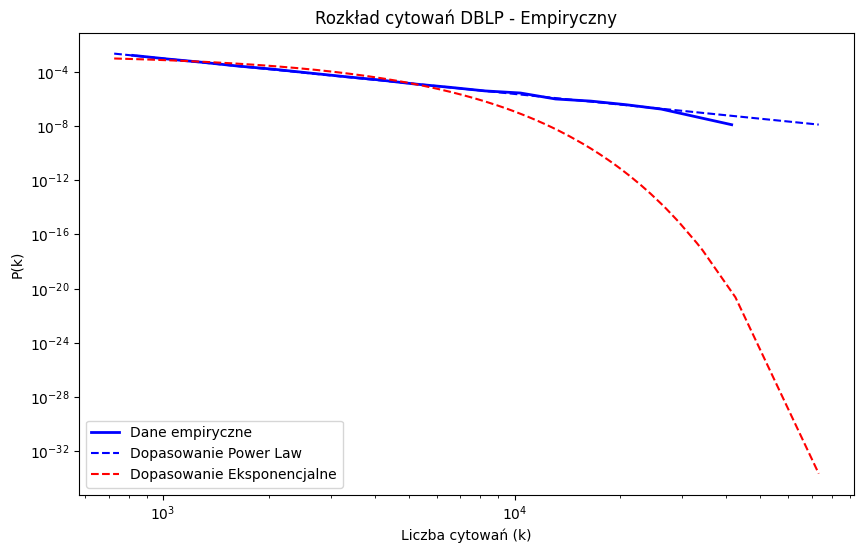

Alpha (empiryczne): 2.613225435638584
Xmin (empiryczne): 726.0


In [4]:
# Przygotowanie danych (lista wszystkich wartości cytowań dla każdej pracy)
fit = powerlaw.Fit(publications, discrete=True)

# Wizualizacja PDF (Probability Density Function)
fig = fit.plot_pdf(color='b', linewidth=2, label='Dane empiryczne')
fit.power_law.plot_pdf(color='b', linestyle='--', ax=fig, label='Dopasowanie Power Law')
fit.exponential.plot_pdf(color='r', linestyle='--', ax=fig, label='Dopasowanie Eksponencjalne')

plt.title("Rozkład cytowań DBLP - Empiryczny")
plt.xlabel("Liczba cytowań (k)")
plt.ylabel("P(k)")
plt.legend()
plt.show()

print(f"Alpha (empiryczne): {fit.power_law.alpha}")
print(f"Xmin (empiryczne): {fit.power_law.xmin}")

## 2. Analiza wyników symulacji 

Wczytujemy dane wygenerowane przez model symulacyjny. Dane te są przechowywane jako słowniki w formacie tekstowym, które musimy sparsować.

In [6]:
# Wczytanie pliku z symulacjami
sim_df = pd.read_csv('distributions_primary_full.csv')

# Funkcja parsująca słownik tekstowy na obiekt Counter
def parse_sim_distribution(dist_str):
    return collections.Counter(ast.literal_eval(dist_str))

# Pobieramy rozkład z pierwszej iteracji (przykładowej)
sim_raw_counts = parse_sim_distribution(sim_df.iloc[0]['distribution'])

# Przetwarzamy na rozkład cytowań (zliczamy wartości ze słownika)
# czyli: ile węzłów ma X cytowań
sim_citation_dist = collections.Counter(sim_raw_counts.values())

# Tworzymy listę obserwacji dla biblioteki powerlaw
sim_observations = []
for citation_count, frequency in sim_citation_dist.items():
    sim_observations.extend([citation_count] * frequency)

print(f"Liczba obserwacji w symulacji: {len(sim_observations)}")

Liczba obserwacji w symulacji: 328826


### 2.1 Weryfikacja hipotez dla symulacji 

Porównujemy dopasowanie rozkładu potęgowego z alternatywami (Lognormal, Exponential) przy użyciu testu Log-Likelihood Ratio.

Calculating best minimal value for power law fit


Assuming nested distributions


Alpha symulacji: 3.595888791526668
D (KS distance): 0.030678586256514984
Power Law vs Exponential: R=1.9919, p=0.0464
Power Law vs Truncated Power Law: R=-2.3278, p=0.0006


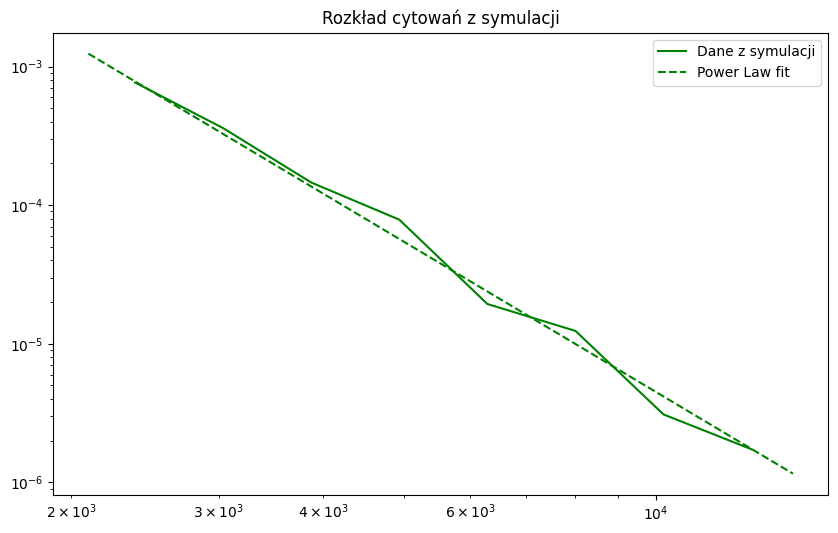

In [7]:
fit_sim = powerlaw.Fit(sim_observations, discrete=True)

# Porównanie modeli
R, p = fit_sim.distribution_compare('power_law', 'exponential', normalized_ratio=True)
R2, p2 = fit_sim.distribution_compare('power_law', 'truncated_power_law', normalized_ratio=True)

print(f"Alpha symulacji: {fit_sim.power_law.alpha}")
print(f"D (KS distance): {fit_sim.power_law.D}")
print(f"Power Law vs Exponential: R={R:.4f}, p={p:.4f}")
print(f"Power Law vs Truncated Power Law: R={R2:.4f}, p={p2:.4f}")

# Wykres log-log dla symulacji
plt.figure()
fit_sim.plot_pdf(color='g', label='Dane z symulacji')
fit_sim.power_law.plot_pdf(color='g', linestyle='--', label='Power Law fit')
plt.title("Rozkład cytowań z symulacji")
plt.legend()
plt.show()

## 3. Porównanie wizualne: Empiryczne vs Eksperymentalne 

Wywołujemy funkcję porównującą PDF i CDF dla obu zbiorów danych jednocześnie.

In [9]:
# Funkcja porównująca PDF i CDF
def pdf_cdf_plot(fit_exp, fit, title):
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))  # Tworzy dwa wykresy obok siebie

    # Wykres PDF (Probability Density Function)
    fit.plot_pdf(color='blue', label='Empirical Fit', linestyle='-', linewidth=2, ax=axs[0])
    fit_exp.plot_pdf(color='red', label='Experimental Fit', linestyle='--', linewidth=2, ax=axs[0])
    axs[0].set_xlabel('Value')
    axs[0].set_ylabel('Probability Density')
    axs[0].set_title(f'{title} - PDF Comparison')
    axs[0].legend()

    # Wykres CDF (Cumulative Distribution Function)
    fit.plot_cdf(color='blue', label='Empirical Fit', linestyle='-', linewidth=2, ax=axs[1])
    fit_exp.plot_cdf(color='red', label='Experimental Fit', linestyle='--', linewidth=2, ax=axs[1])
    axs[1].set_xlabel('Value')
    axs[1].set_ylabel('Cumulative Probability')
    axs[1].set_title(f'{title} - CDF Comparison')
    axs[1].legend()

    plt.tight_layout()
    # Zapisywanie wykresu (upewnij się, że folder istnieje)
    if not os.path.exists('../reports/figures/'):
        os.makedirs('../reports/figures/')
    plt.savefig(f'../reports/figures/pdf_cdf_plot_{title.replace(" ", "_")}.png', bbox_inches='tight')
    plt.show()

In [13]:
# Wczytanie danych empirycznych
dblp_df = pd.read_csv('dblp_distribution_citations.csv')
src_dist = ast.literal_eval(dblp_df.iloc[0,0])

# Przygotowanie danych do powerlaw
sorted_keys = sorted(src_dist.keys())
sorted_values = [src_dist[key] for key in sorted_keys]

# Obiekt fit dla danych empirycznych
fit = powerlaw.Fit(sorted_values, discrete=True)
print(f"Alpha (Empiryczne): {fit.power_law.alpha}")

Calculating best minimal value for power law fit
Alpha (Empiryczne): 1.4269236243606653


In [12]:
# Wczytanie wyników symulacji
sim_df = pd.read_csv('distributions_primary_full.csv')

# Pobieramy rozkład z pierwszej iteracji
row = sim_df.iloc[0]
dist_dict = ast.literal_eval(row['distribution'])
# Obliczamy ile razy wystąpiła każda liczba cytowań (citation distribution)
cit_counts = collections.Counter(dist_dict.values())
sim_sorted_values = [cit_counts[k] for k in sorted(cit_counts.keys())]

# Obiekt fit dla danych z symulacji
fit_exp = powerlaw.Fit(sim_sorted_values, discrete=True)
print(f"Alpha (Eksperymentalne): {fit_exp.power_law.alpha}")

Calculating best minimal value for power law fit
Alpha (Eksperymentalne): 1.4362211551576145


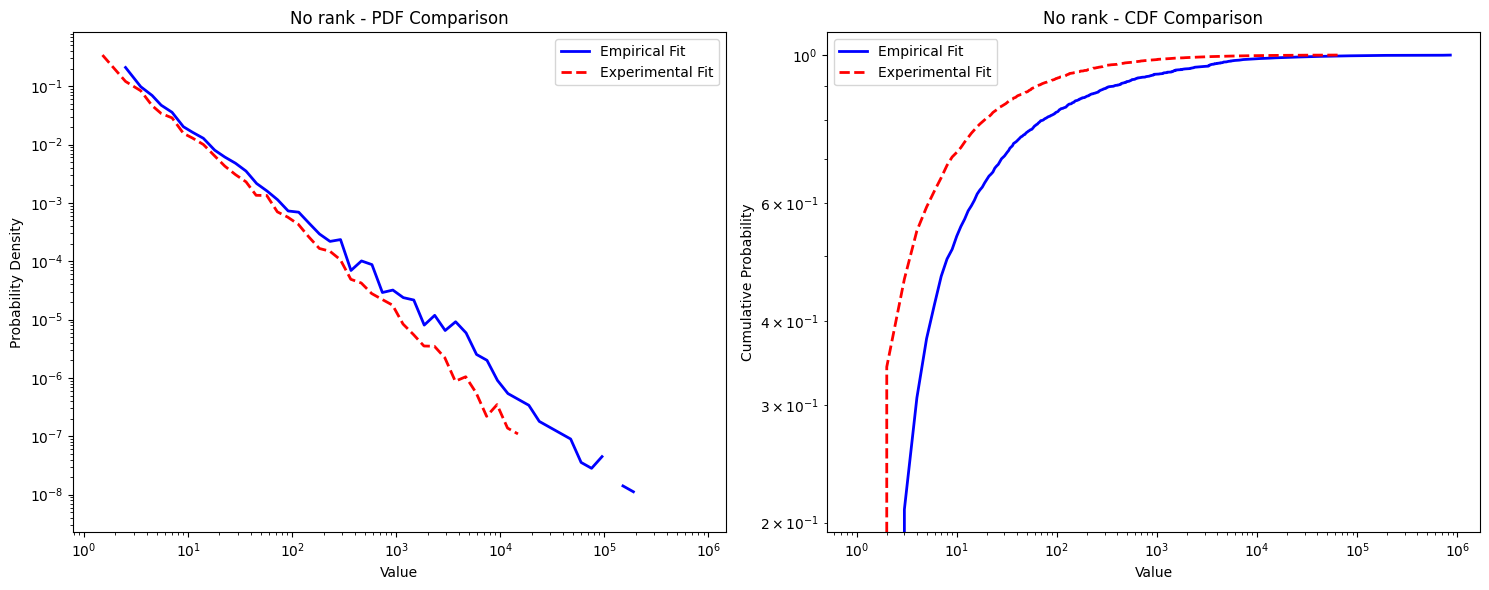

In [14]:
# Wywołanie Twojej funkcji pdf_cdf_plot
# Integruje ona wyniki z Sekcji 1 (fit) i Sekcji 2 (fit_exp)
pdf_cdf_plot(fit_exp, fit, "No rank")

## Podsumowanie 

Porównujemy parametry Alfa dla obu zestawów danych.

In [8]:
comparison_data = {
    "Metryka": ["Alpha (Nachylenie)", "Xmin"],
    "DBLP (Empiryczne)": [fit.power_law.alpha, fit.power_law.xmin],
    "Symulacja": [fit_sim.power_law.alpha, fit_sim.power_law.xmin]
}
print(pd.DataFrame(comparison_data))

              Metryka  DBLP (Empiryczne)    Symulacja
0  Alpha (Nachylenie)           2.613225     3.595889
1                Xmin         726.000000  2096.000000
